# Data Mining the Water Table

In [108]:
!pip install squarify

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [146]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas.api.types import is_string_dtype, is_numeric_dtype

import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic
import squarify

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from scipy.cluster import hierarchy as hc

from sklearn.model_selection import train_test_split

In [122]:
x_train = pd.read_csv('https://raw.githubusercontent.com/kayoyin/datasets/master/x_train.csv', parse_dates = ['date_recorded'])
y_train = pd.read_csv('https://raw.githubusercontent.com/kayoyin/datasets/master/y_train.csv')
x_test = pd.read_csv('https://raw.githubusercontent.com/kayoyin/datasets/master/x_test.csv', parse_dates = ['date_recorded'])

In [119]:
print(x_train.shape, y_train.shape, x_test.shape)

(59400, 40) (59400, 2) (14850, 40)


In [38]:
x_train.head().T

,0,1,2,3,4
id,69572,8776,34310,67743,19728
amount_tsh,6000,0,25,0,0
date_recorded,2011-03-14,2013-03-06,2013-02-25,2013-01-28,2011-07-13
funder,Roman,Grumeti,Lottery Club,Unicef,Action In A
gps_height,1390,1399,686,263,0
installer,Roman,GRUMETI,World vision,UNICEF,Artisan
longitude,34.9381,34.6988,37.4607,38.4862,31.1308
latitude,-9.85632,-2.14747,-3.82133,-11.1553,-1.82536
wpt_name,none,Zahanati,Kwa Mahundi,Zahanati Ya Nanyumbu,Shuleni
num_private,0,0,0,0,0


In [6]:
y_train.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [53]:
y_num = y_train.replace(['functional','non functional', 'functional needs repair'], [0,1,2])
data_viz = pd.concat([x_train,y_train['status_group']],axis=1)
labels = pd.get_dummies(y_train)

# Exploratory Data Analysis

In [37]:
print("Number of water tables per status: \n", y_train.sum()[1:])
x_train.isnull().sum()

Number of water tables per status: 
 status_group_functional                 32259
status_group_functional needs repair     4317
status_group_non functional             22824
dtype: int64


id                           0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

In [41]:
cat_df = pd.DataFrame(columns=["Feature", "Cardinality","% Missings"])

total_cardinality = 0

i=0

for col in x_train.columns:
    if (x_train[col].dtype == np.object):
        cat_df.loc[i,"Feature"] = col
        cat_df.loc[i,"Cardinality"] = len(x_train[col].unique())
        total_cardinality += len(x_train[col].unique())
        pct_of_missing_values = float((len(x_train[col]) - x_train[col].count()) / len(x_train[col]))
        cat_df.loc[i,"% Missings"] = pct_of_missing_values*100
        i+=1

print("Total cardinality of categorical features:",total_cardinality)

cat_df

Total cardinality of categorical features: 66178


,Feature,Cardinality,% Missings
0,date_recorded,356,0
1,funder,1898,6.11953
2,installer,2146,6.1532
3,wpt_name,37400,0
4,basin,9,0
5,subvillage,19288,0.624579
6,region,21,0
7,lga,125,0
8,ward,2092,0
9,public_meeting,3,5.61279


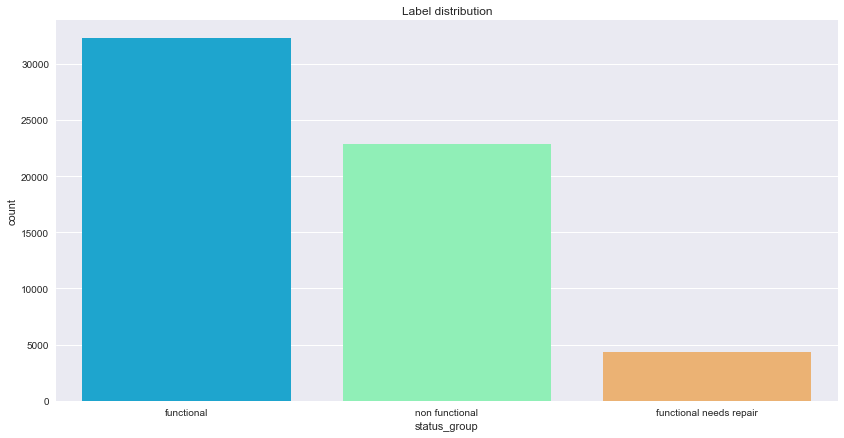

In [59]:
plt.figure(figsize=(14,7))
sns.countplot(x='status_group',data=y_train, palette="rainbow")
plt.title("Label distribution")
plt.show()

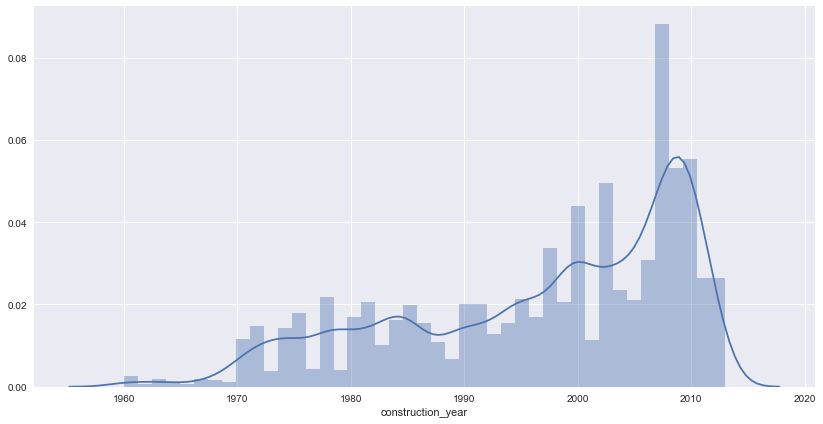

In [60]:
plt.figure(figsize=(14,7))
sns.distplot(data_viz['construction_year'][data_viz['construction_year']>0])
plt.show()

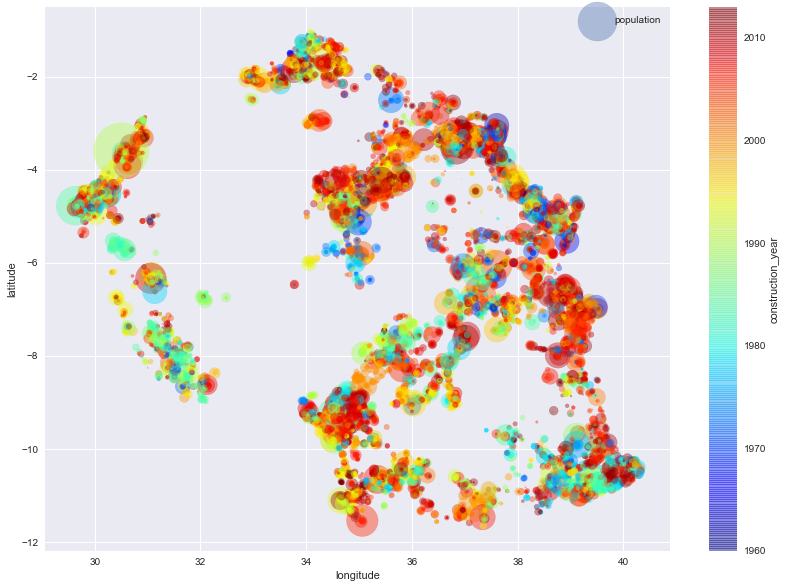

In [64]:
#Water pump geographical distribution with population proportional circles and year of pump color bar

plt.figure(figsize=(14,7))
data_viz[data_viz['longitude']>0][data_viz['latitude']<0][data_viz['construction_year']>0].plot\
    (kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=data_viz["population"]/10, label="population", figsize=(14,10),
    c="construction_year", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()
plt.show()

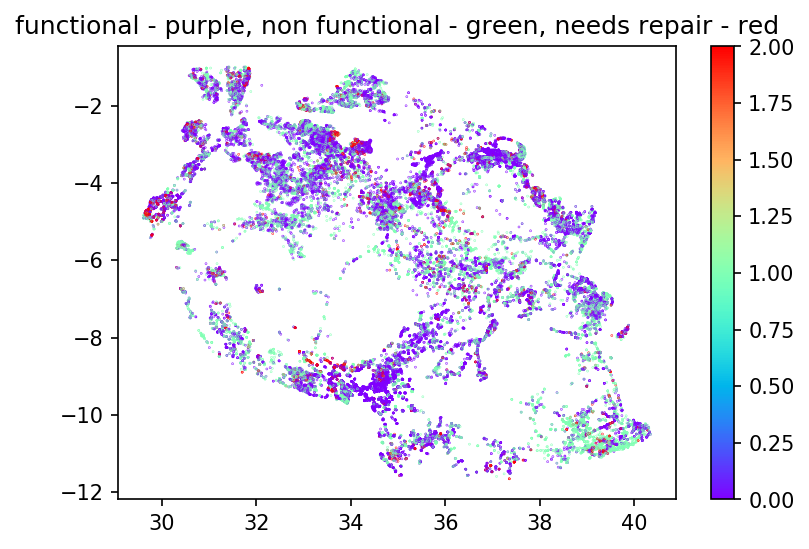

In [17]:
plt.figure(1,dpi=150)
x_geo = x_train.drop(x_train[x_train['longitude'] == 0].index)
y_geo = y_num.drop(x_train[x_train['longitude'] == 0].index)
plt.scatter(x_geo['longitude'], x_geo['latitude'], c = y_geo.iloc[:,1], cmap = 'rainbow', s = 0.05)
plt.title("functional - purple, non functional - green, needs repair - red")
plt.colorbar()
plt.show()

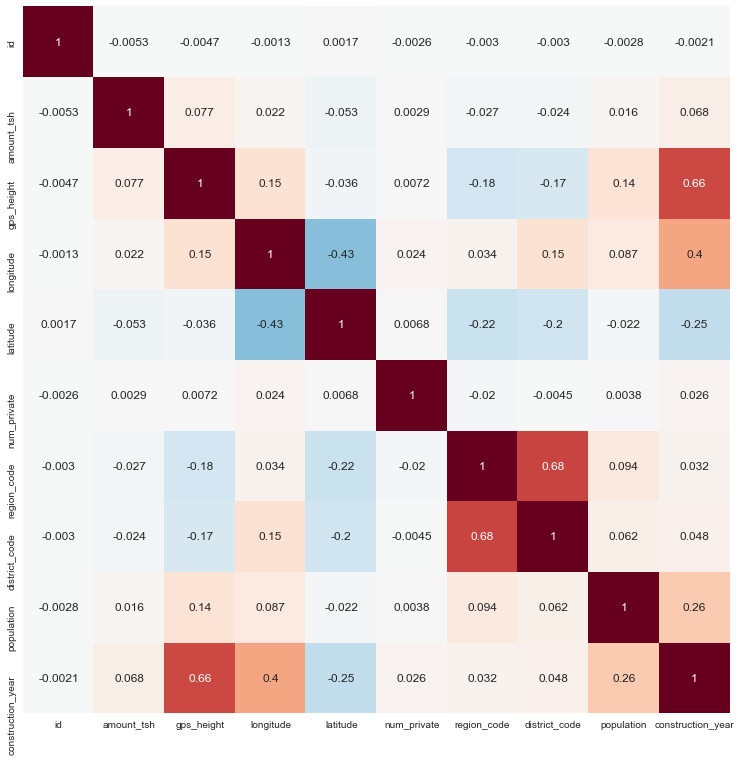

In [75]:
cor = data_viz.corr()
plt.figure(figsize=(14,13))
sns.heatmap(cor, square=True, annot=True, cbar=False)
plt.show()

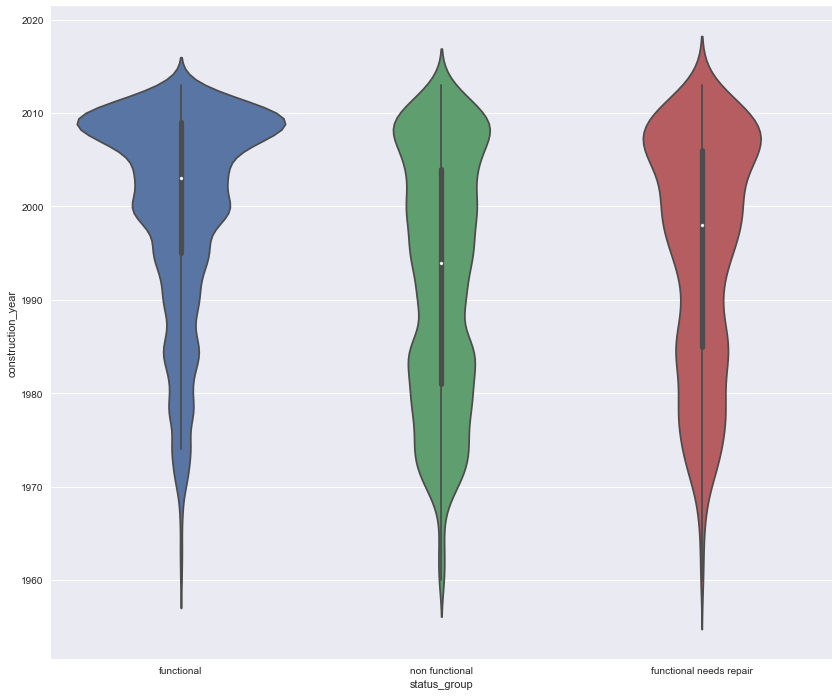

In [68]:
fig, ax = plt.subplots(figsize=(14,12));
ax = sns.violinplot(x='status_group', y="construction_year",\
                    data=data_viz[data_viz['construction_year']>0], split=True)
plt.show()

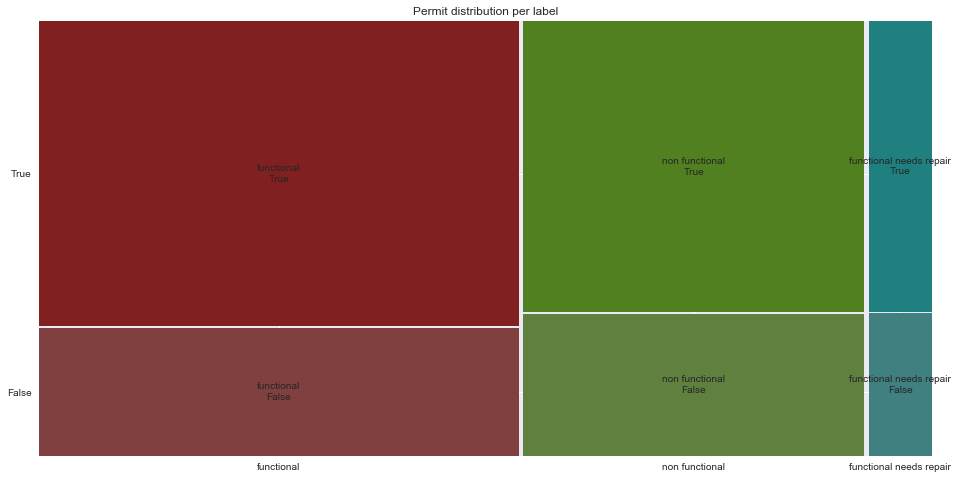

In [76]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 8))
mosaic(data_viz, ['status_group', 'permit'], axes, title="Permit distribution per label")
plt.show()

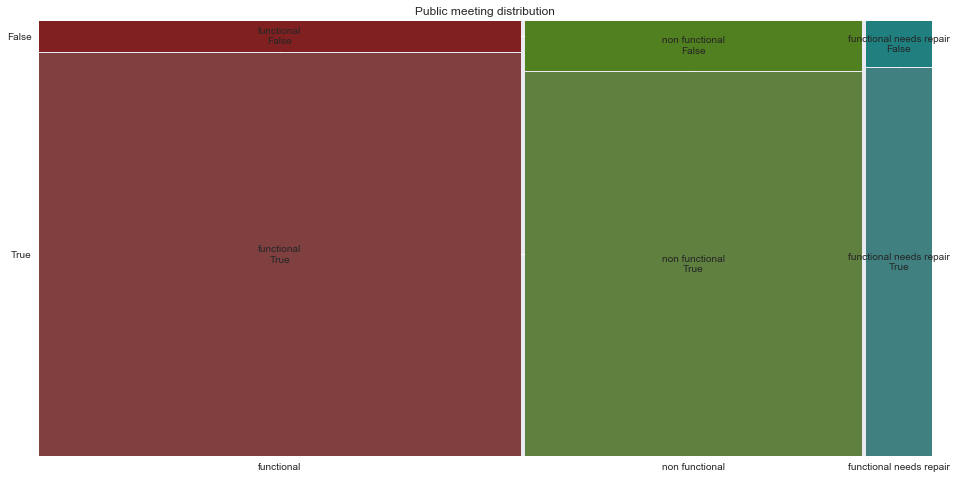

In [77]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 8))
mosaic(data_viz, ['status_group', 'public_meeting'], axes, title="Public meeting distribution")
plt.show()

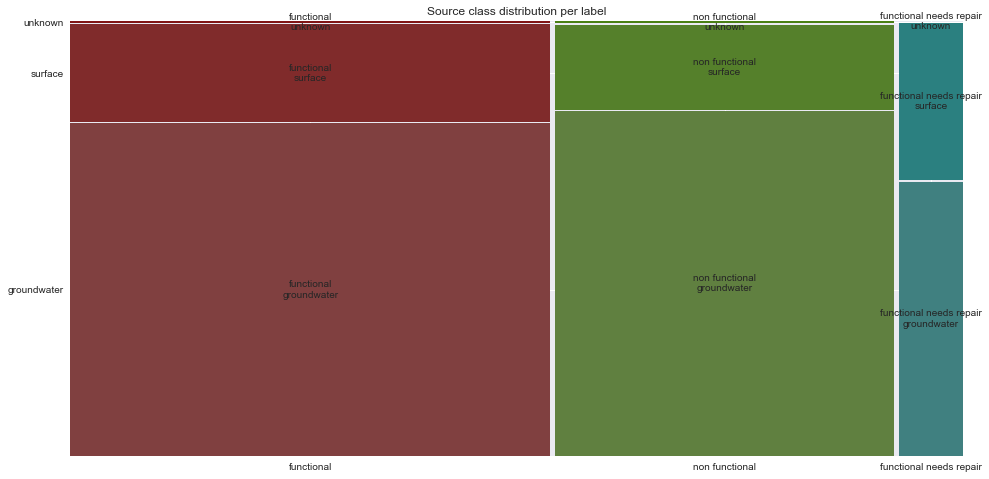

In [78]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 8))
mosaic(data_viz, ['status_group', 'source_class'], axes, title="Source class distribution per label")
plt.show()

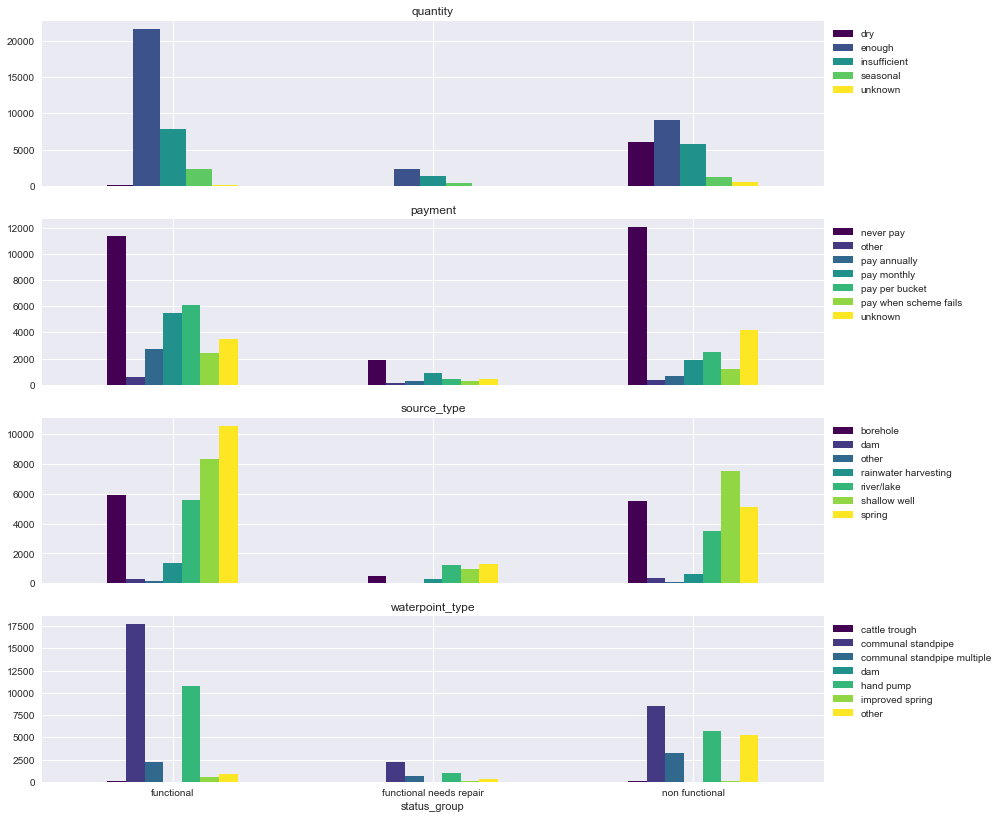

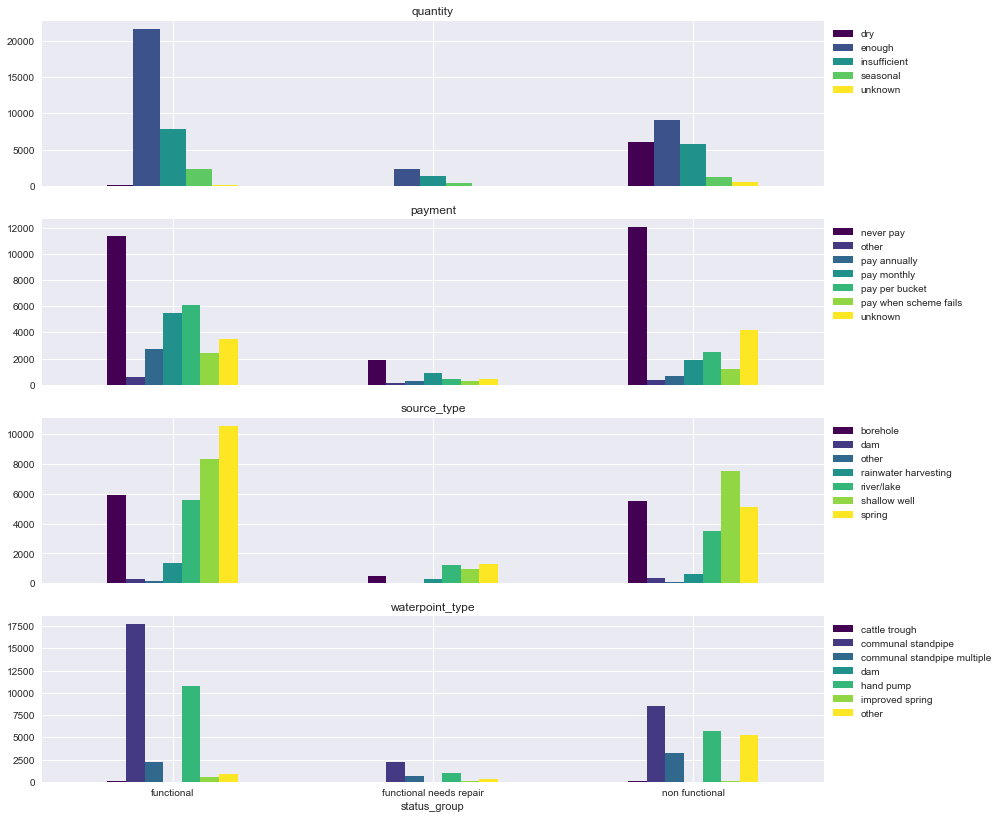

In [80]:
variables = ['quantity','payment','source_type','waterpoint_type']
label = 'status_group'

def plot_tables(data,label,variables):
    fig, axes = plt.subplots(nrows=len(variables), ncols=1, figsize = (14,14))
    for i,variable in enumerate(variables):
        ax = pd.pivot_table(data[[label,variable]], index = [label,variable], aggfunc = len)\
        .unstack(variable).plot(kind='bar', ax=axes[i], sharex=True, title=variable, rot=0, colormap='viridis')
        ax.legend(bbox_to_anchor=(1,1),loc="upper left")
    plt.show()
        
plot_tables(data_viz,label,variables)

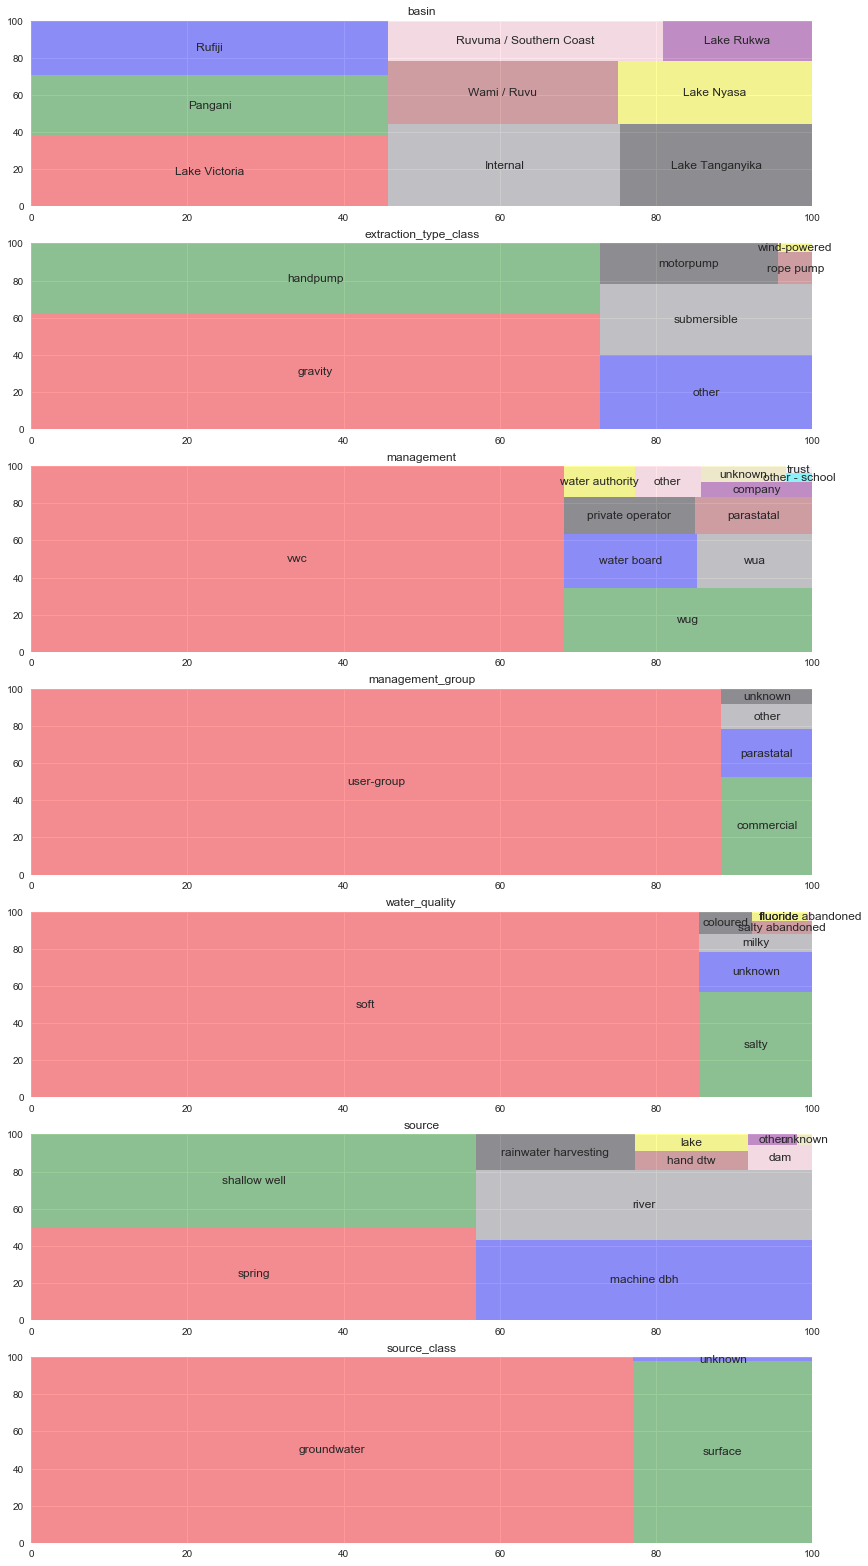

In [87]:
variables = ['basin','extraction_type_class','management','management_group',
             'water_quality','source','source_class']
colors = ["red","green","blue", "grey", "black", "brown", "yellow", "pink", "purple", "khaki", "cyan","white"]

def plot_proportions(data,variables):
    fig, axes = plt.subplots(nrows=len(variables), ncols=1, figsize = (14,len(variables)*4))
    for i,variable in enumerate(variables):
        ax = squarify.plot(sizes=data[variable].value_counts().tolist(), 
                      label=data[variable].value_counts().index.tolist(), color=colors, ax=axes[i], alpha=.4)
        ax.set_title(variable)
    plt.show()
        
plot_proportions(data_viz,variables)

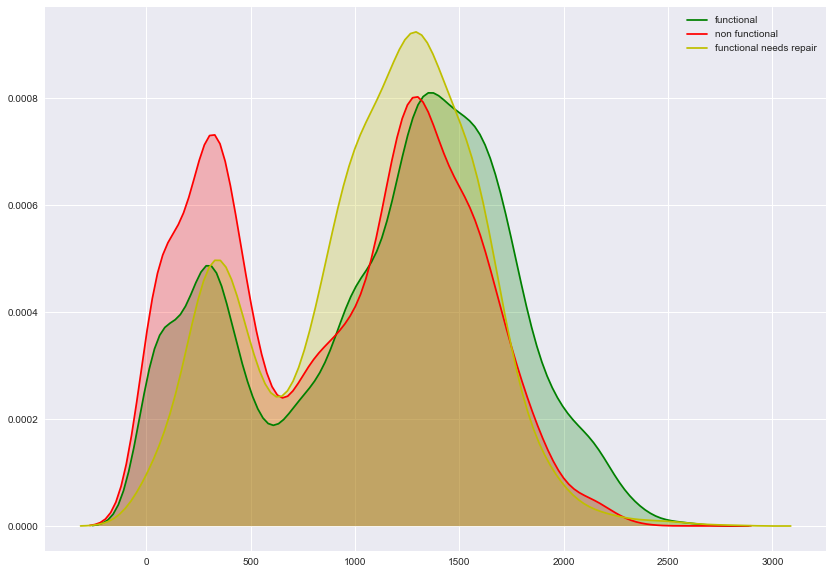

In [89]:
# Height distrinbution per label
plt.figure(figsize=(14,10))

p1=sns.kdeplot(data_viz[['gps_height','status_group']][data_viz.status_group == 'functional']
               [data_viz.gps_height > 0].gps_height, shade=True, color="g",label='functional')
p1=sns.kdeplot(data_viz[['gps_height','status_group']][data_viz.status_group == 'non functional']
               [data_viz.gps_height > 0].gps_height, shade=True, color="r",label='non functional')
p1=sns.kdeplot(data_viz[['gps_height','status_group']][data_viz.status_group == 'functional needs repair']
               [data_viz.gps_height > 0].gps_height, shade=True, color="y",label='functional needs repair')

plt.show()

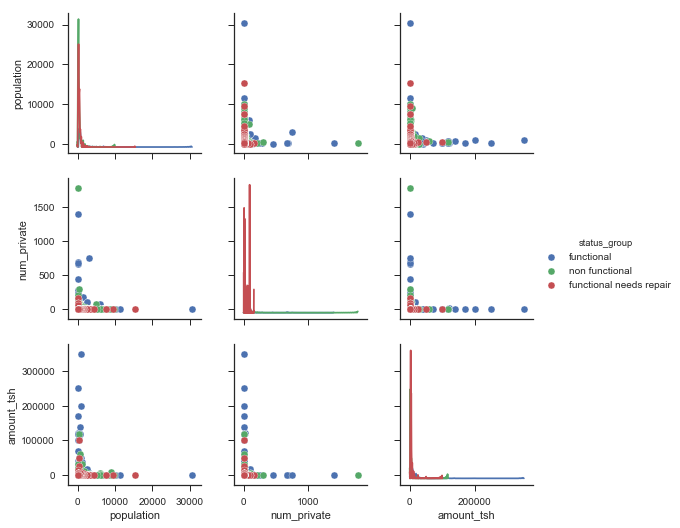

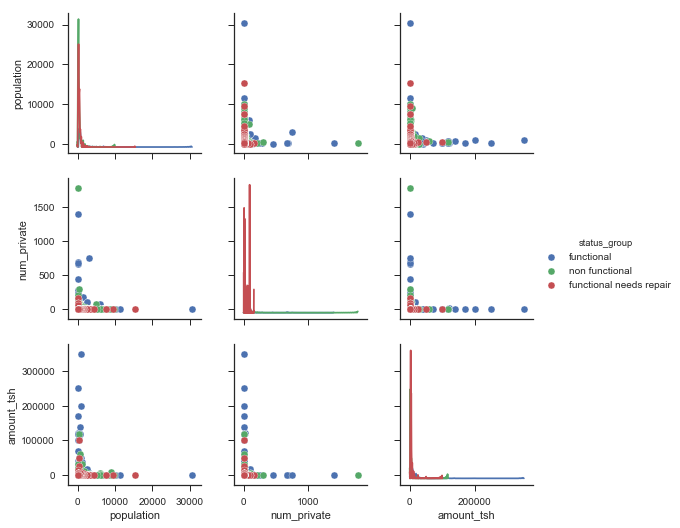

In [91]:
#Pair plot of the relevant numerical features against each other, differentiating by label value
sns.set(style="ticks")
sns.pairplot(data_viz[['population','num_private','amount_tsh','status_group']],
                    hue="status_group", diag_kind="kde")
plt.show()

# Data Preparation

In [123]:
# Drop recorded_by column (constant value)
x_train.drop(['recorded_by'], axis=1, inplace=True)
x_test.drop(['recorded_by'], axis=1, inplace=True)
# Drop values with high cardinality
x_train.drop(['funder', 'installer', 'lga', 'scheme_name', 'subvillage', 'ward', 'wpt_name'], axis=1, inplace=True)
x_test.drop(['funder', 'installer', 'lga', 'scheme_name', 'subvillage', 'ward', 'wpt_name'], axis=1, inplace=True)

In [138]:
# Function retrieved and adapted from fastai library
def add_datepart(df, fldname, mindate):
    fld = df[fldname]
    targ_pre = re.sub('[Dd]ate$','', fldname)
    df[targ_pre+'Month'] = getattr(fld.dt,'Month'.lower())
    df[targ_pre+'Elapsed'] = (fld - mindate).dt.days
    df.drop(fldname, axis=1, inplace=True)

In [139]:
add_datepart(x_train, 'date_recorded', x_test['date_recorded'].min())
add_datepart(x_test, 'date_recorded',x_test['date_recorded'].min())

In [143]:
x_train['date_recordedElapsed'].min()

567

In [144]:
# Turn all data types into categorical data types
def train_cats(df):
     for n,c in df.items():
        if is_string_dtype(c): df[n] = c.astype('category').cat.as_ordered()

In [150]:
train_cats(x_train)
train_cats(x_test)
x_train.isnull().sum().sort_index()/len(x_train)
# x_test.isnull().sum().sort_index()/len(x_test)

amount_tsh               0.000000
basin                    0.000000
construction_year        0.000000
date_recordedElapsed     0.000000
date_recordedMonth       0.000000
district_code            0.000000
extraction_type          0.000000
extraction_type_class    0.000000
extraction_type_group    0.000000
gps_height               0.000000
id                       0.000000
latitude                 0.000000
longitude                0.000000
management               0.000000
management_group         0.000000
num_private              0.000000
payment                  0.000000
payment_type             0.000000
permit                   0.051448
population               0.000000
public_meeting           0.056128
quality_group            0.000000
quantity                 0.000000
quantity_group           0.000000
region                   0.000000
region_code              0.000000
scheme_management        0.065269
source                   0.000000
source_class             0.000000
source_type   

In [152]:
x_train['permit'].fillna(x_train['permit'].mode()[0], inplace=True)
x_test['permit'].fillna(x_test['permit'].mode()[0], inplace=True)

x_train['public_meeting'].fillna(x_train['public_meeting'].mode()[0], inplace=True)
x_test['public_meeting'].fillna(x_test['public_meeting'].mode()[0], inplace=True)

x_train['scheme_management'].fillna(x_train['scheme_management'].mode()[0], inplace=True)
x_test['scheme_management'].fillna(x_test['scheme_management'].mode()[0], inplace=True)

In [153]:
x_train.isnull().sum().sort_index()/len(x_train)
# x_test.isnull().sum().sort_index()/len(x_test)

amount_tsh               0.0
basin                    0.0
construction_year        0.0
date_recordedElapsed     0.0
date_recordedMonth       0.0
district_code            0.0
extraction_type          0.0
extraction_type_class    0.0
extraction_type_group    0.0
gps_height               0.0
id                       0.0
latitude                 0.0
longitude                0.0
management               0.0
management_group         0.0
num_private              0.0
payment                  0.0
payment_type             0.0
permit                   0.0
population               0.0
public_meeting           0.0
quality_group            0.0
quantity                 0.0
quantity_group           0.0
region                   0.0
region_code              0.0
scheme_management        0.0
source                   0.0
source_class             0.0
source_type              0.0
water_quality            0.0
waterpoint_type          0.0
waterpoint_type_group    0.0
dtype: float64

In [155]:
notnumber = list(x_train.select_dtypes(exclude=[np.number]))
print(notnumber)

['basin', 'region', 'public_meeting', 'scheme_management', 'permit', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group']


In [156]:
dummy_train = pd.get_dummies(x_train, notnumber)
dummy_test = pd.get_dummies(x_test, notnumber)

# Training

In [111]:
trainx, validx, trainy, validy = train_test_split(x_train, y_train, test_size = x_test.shape[0])